In [41]:
#import numpy as np
from jax import grad
import jax.numpy as jnp
import jax
from jax import jit

from jax import random

from jax import scipy

import time, datetime

import matplotlib.pyplot as plt

from jax import vmap, jit

In [42]:
from jax.config import config
config.update("jax_enable_x64", True)

In [43]:
jax.default_backend()

'cpu'

# Using vmap

In [44]:
key = random.PRNGKey(0)

X = random.normal(key, (1000, 2))

Y = random.normal(key, (5000, 2))

l = 2.0

In [45]:

def matern_kernel(x, y, length_scale):
    r = jnp.sqrt(jnp.sum((x - y) ** 2))
    #factor =r / length_scale
    return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)


# def matern_kernel(x, y, length_scale):
#     r = jnp.sum((x - y) ** 2)
#     #factor =r / length_scale
#     return jnp.exp(-r/(2*length_scale**2))


vmap_kernel_row = jax.vmap(matern_kernel, in_axes=(None, 0, None))
# Now we apply vmap to the result to vectorize over the rows of the first argument
vmap_kernel = jax.vmap(vmap_kernel_row, in_axes=(0, None, None))

In [46]:
start = time.time()
#m1 = kernel(X,X, l).block_until_ready()
m1= vmap_kernel(X,X, l).block_until_ready()
print(m1.shape)
end = time.time()

print(str(datetime.timedelta(seconds=end-start)))

(1000, 1000)
0:00:00.043288


# Defining the test functions

In [47]:
import jax.numpy as jnp
from jax import vmap

def bump(x, epsilon, loc):
    condition = (loc - epsilon < x) & (x < loc + epsilon)
    return jnp.where(
        condition,
        jnp.exp(-1 / (1 - (x - loc) ** 2 / epsilon ** 2))/epsilon,
        0.0
    )
    
vmap_bump = jit(vmap(bump, in_axes=(0, None, None)))

In [48]:
loc = .0
epsilon = 0.1
bump(100, epsilon, loc)

Array(0., dtype=float64, weak_type=True)

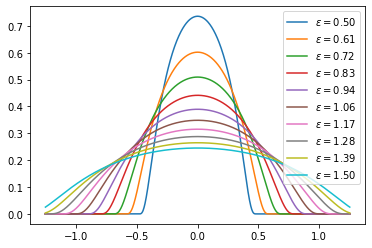

In [49]:
epsilon_values = jnp.linspace(0.5, 1.5, 10)

loc = 0.0
domain = jnp.linspace(-1.25, 1.25, 1000)

for epsilon in epsilon_values:
    plt.plot(domain, vmap_bump(domain, epsilon, loc), label = f"$\epsilon = {epsilon:.2f}$")
plt.legend()

In [50]:

# First vectorization over 'loc'
vectorized_over_loc = vmap(bump, in_axes=(None, None, 0))

# Second vectorization over 'epsilon'
vectorized_over_epsilon = vmap(vectorized_over_loc, in_axes=(None, 0, None))

# Final vectorization over 'x_values'
vmap_bump = vmap(vectorized_over_epsilon, in_axes=(0, None, None))

# Example usage with differently sized arrays for each parameter
x_values = jnp.array([0.1, 0.2, 0.3])  # m-sized array
epsilons = jnp.array([0.05, 0.1])      # n-sized array
locs = jnp.array([0.15, 0.25, 0.35, 0.45])  # d-sized array

# The result will be a d x n x m array
results = vmap_bump(x_values, epsilons, locs)

# Check the shape of the result to confirm it's d x n x m
assert results.shape == (len(x_values),  len(epsilons), len(locs))
print(results.shape)


(3, 2, 4)


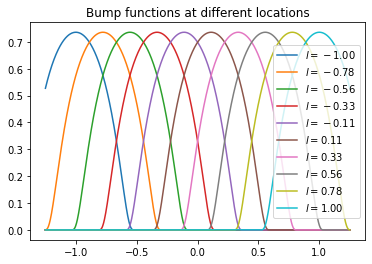

In [51]:
epsilon_values = jnp.array([0.5])
loc_values = jnp.linspace(-1.0, 1.0, 10)
domain = jnp.linspace(-1.25, 1.25, 1000)

bump_values = vmap_bump(domain, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(domain, bump_values[:, 0, i], label = f"$l = {loc:.2f}$")
plt.legend()


plt.legend()
plt.title("Bump functions at different locations")
plt.show()

# Forming the kernel matrix

The kernel matrix will have the form 

$$
K(\phi, \phi ) = \begin{bmatrix}
K(X, X) & K(X, \chi) \\
K(\chi, X) & K(\chi, \chi)
\end{bmatrix}
$$

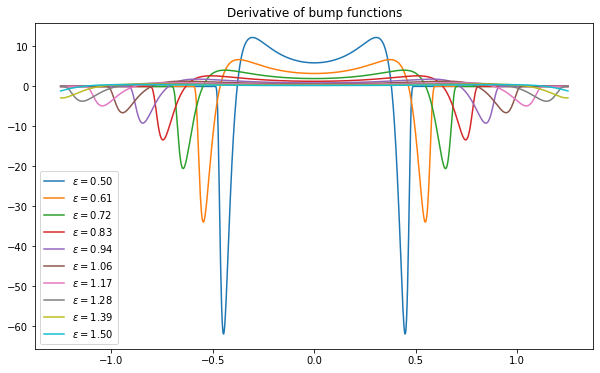

In [52]:

def bump_laplacian(x, epsilon, l):
    # Define the condition for the 'bump'
    condition = (l - epsilon < x) & (x < l + epsilon)
    
    # Define the numerator
    numerator = (
        2 * epsilon**2 *
        (3 * x**4 - 12 * l * x**3 + 18 * l**2 * x**2 - 12 * l**3 * x + 3 * l**4 - epsilon**4) *
        jnp.exp(-1 / (1 - ((x - l)**2 / epsilon**2)))
    )
    
    # Define the denominator
    denominator = (x**2 - 2 * l * x + l**2 - epsilon**2)**4
    
    # Use where to apply the condition
    result = jnp.where(condition, numerator / denominator, 0.0)
    
    return -result/epsilon

# Vectorize the bum_laplacian function
vmap_bump_laplacian = vmap(bump_laplacian, in_axes=(0, None, None))


epsilon_values =  jnp.linspace(0.5, 1.5, 10)

loc = 0.0
domain = jnp.linspace(-1.25, 1.25, 1000)

plt.figure(figsize=(10, 6))

for epsilon in epsilon_values:
    plt.plot(domain, vmap_bump_laplacian(domain, epsilon, loc), label = f"$\epsilon = {epsilon:.2f}$")
plt.legend()
plt.title("Derivative of bump functions")
plt.show()

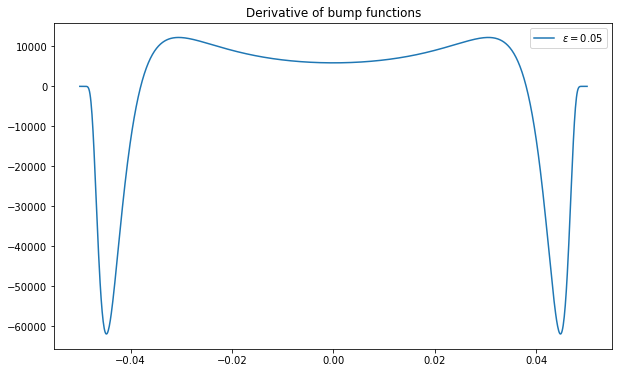

In [53]:

epsilon_values =  jnp.array([0.05])

loc = loc = jnp.array([0.0])
domain = jnp.linspace(-epsilon_values[0], epsilon_values[0], 1000)

plt.figure(figsize=(10, 6))

for epsilon in epsilon_values:
    plt.plot(domain, vmap_bump_laplacian(domain, epsilon, loc), label = f"$\epsilon = {epsilon:.2f}$")
plt.legend()
plt.title("Derivative of bump functions")
plt.show()

In [54]:
# We will use autograd to compute the second derivative

def laplacian_bump(x, epsilon, loc):
    condition = (loc - epsilon < x) & (x < loc + epsilon)

    return -jnp.where(
        condition,
        grad(grad(bump, argnums =0), argnums=0)(x, epsilon, loc),
        0.0
    )

# Now you can call second_derivative with scalar values
x_value = 0.99# This is a scalar for x
epsilon_value = 1.0  # This is a scalar for epsilon
loc_value = 0.0  # This is a scalar for loc

second_derivative_value = laplacian_bump(x_value, epsilon_value, loc_value)
vmap_laplacian_bump = vmap(laplacian_bump, in_axes=(0, None, None))


domain = jnp.linspace(-1.1, 1.1, 10)
vmap_laplacian_bump(domain, epsilon_value, loc_value) , vmap_bump_laplacian(domain, epsilon_value, loc_value), 

(Array([-0.        , -5.64192093,  1.52997103,  1.06141524,  0.76913912,
         0.76913912,  1.06141524,  1.52997103, -5.64192093, -0.        ],      dtype=float64),
 Array([-0.        , -5.64192093,  1.52997103,  1.06141524,  0.76913912,
         0.76913912,  1.06141524,  1.52997103, -5.64192093, -0.        ],      dtype=float64))

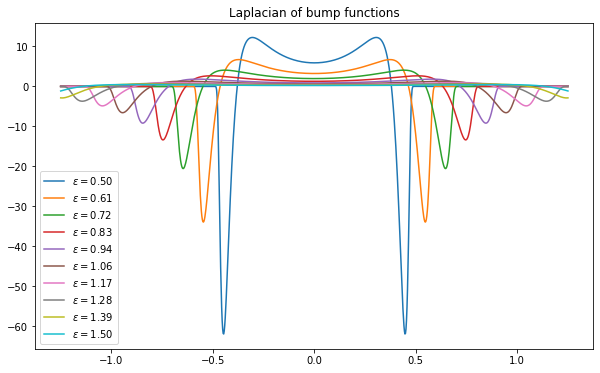

In [55]:

epsilon_values = jnp.linspace(0.5, 1.5, 10)

loc = 0.0
domain = jnp.linspace(-1.25, 1.25, 1000)

plt.figure(figsize=(10, 6))

for epsilon in epsilon_values:
    plt.plot(domain, vmap_laplacian_bump(domain, epsilon, loc), label = f"$\epsilon = {epsilon:.2f}$")
plt.legend()
plt.title("Laplacian of bump functions")
plt.show()

In [56]:
# Speed test! The exact expression is much faster than using autograd (by a factor of 2)

# Using autograd

epsilon_value = 1.0  # This is a scalar for epsilon 
loc_value = 0.0  # This is a scalar for loc

domain = jnp.linspace(-1.5, 1.5, 10000)

start = time.time()
lapl_1 = vmap_laplacian_bump(domain, epsilon_value, loc_value).block_until_ready()
end = time.time()

print(str(datetime.timedelta(seconds=end-start)))

# Using the exact expression 
start = time.time()
lapl_2 = vmap_bump_laplacian(domain, epsilon_value, loc_value).block_until_ready()
end = time.time()

print(str(datetime.timedelta(seconds=end-start)))


jnp.allclose(lapl_1, lapl_2)    

0:00:00.026360
0:00:00.012197


Array(True, dtype=bool)

In [57]:
# Vmapping the laplacian_bump function over the epsilon and loc parameters


# Vectorize the bump_laplacian function over all three arguments

# First vectorization over 'l'
vectorized_over_l = vmap(bump_laplacian, in_axes=(None, None, 0))

# Second vectorization over 'epsilon'
vectorized_over_epsilon = vmap(vectorized_over_l, in_axes=(None, 0, None))

# Final vectorization over 'x'
vmap_bump_laplacian = vmap(vectorized_over_epsilon, in_axes=(0, None, None))

# Example usage with differently sized arrays for each parameter
x_values = jnp.array([0.1, 0.2, 0.3])   # m-sized array
epsilons = jnp.array([0.05, 0.1])       # n-sized array
ls = jnp.array([0.15, 0.25, 0.35, 0.45])  # d-sized array

# The result will be a d x n x m array
results = vmap_bump_laplacian(x_values, epsilons, ls)

# Check the shape of the result to confirm it's d x n x m

print("The shape of the result is:", results.shape)


The shape of the result is: (3, 2, 4)


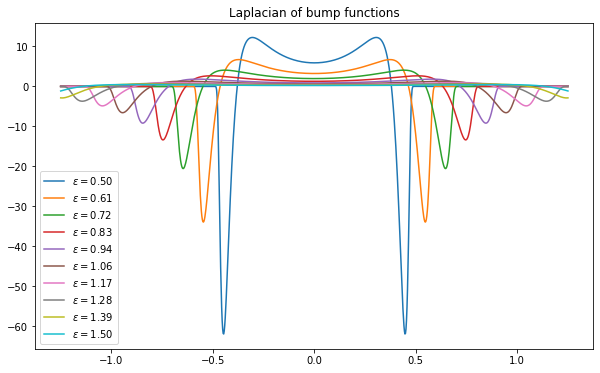

In [58]:

epsilon_values = jnp.linspace(0.5, 1.5, 10)

loc = jnp.array([0.0])
domain = jnp.linspace(-1.25, 1.25, 1000)

bump_laplacian_values = vmap_bump_laplacian(domain, epsilon_values, loc)

plt.figure(figsize=(10, 6))

for i, epsilon in enumerate(epsilon_values):
    plt.plot(domain, bump_laplacian_values[:, i, 0], label = f"$\epsilon = {epsilon:.2f}$")
plt.legend()
plt.title("Laplacian of bump functions")
plt.show()

We need to compute 

$$
K(X, \chi) = \int K(X,y)L^*\psi \approx \sum_{i=1}^Q K(X, y_i) L^*\psi(y_i) = K(X,X_Q)A_L \\
K(\chi, \chi) = \int \int L^*\psi(x) K(x,y)  L^*\psi(y) dx dy \approx \sum_{i=1}^Q\sum_{j=1}^Q L^*\psi(x_i) K(x_i, x_j) L^*\psi(x_j) = A_L^T K(X_Q, X_Q) A_L
$$


In [81]:
# Define the quarature points and weights

from scipy.special import roots_legendre

# Define the order of the polynomial 

n_order = 1000

x_q, w_q = roots_legendre(n_order)

def root_interval(x_q, w_q, interval):
    # Defines the roots of the interval [a,b]
    a= interval[0]
    b= interval[1]
    return (b-a)/2*x_q + (b+a)/2, (b - a) / 2 * w_q

# def root_interval(x_q, w_q, interval):
#     # Defines the roots of the interval [a,b]
#     a= interval[0]
#     b= interval[1]
#     return (b-a)/2*x_q + (b+a)/2,w_q
vmap_root_interval = vmap(root_interval, in_axes=(None,None,  0))
w_q.shape

(1000,)

In [82]:
root_psi, w_psi = vmap_root_interval(x_q, w_q, bump_intervals.T)

In [83]:
w_psi

Array([[3.70666914e-07, 8.62838490e-07, 1.35573033e-06, ...,
        1.35573033e-06, 8.62838490e-07, 3.70666914e-07],
       [3.70666914e-07, 8.62838490e-07, 1.35573033e-06, ...,
        1.35573033e-06, 8.62838490e-07, 3.70666914e-07],
       [3.70666914e-07, 8.62838490e-07, 1.35573033e-06, ...,
        1.35573033e-06, 8.62838490e-07, 3.70666914e-07],
       ...,
       [3.70666914e-07, 8.62838490e-07, 1.35573033e-06, ...,
        1.35573033e-06, 8.62838490e-07, 3.70666914e-07],
       [3.70666914e-07, 8.62838490e-07, 1.35573033e-06, ...,
        1.35573033e-06, 8.62838490e-07, 3.70666914e-07],
       [3.70666914e-07, 8.62838490e-07, 1.35573033e-06, ...,
        1.35573033e-06, 8.62838490e-07, 3.70666914e-07]], dtype=float64)

In [80]:
w_psi

Array([[7.41333828e-06, 1.72567698e-05, 2.71146065e-05, ...,
        2.71146065e-05, 1.72567698e-05, 7.41333828e-06],
       [7.41333828e-06, 1.72567698e-05, 2.71146065e-05, ...,
        2.71146065e-05, 1.72567698e-05, 7.41333828e-06],
       [7.41333828e-06, 1.72567698e-05, 2.71146065e-05, ...,
        2.71146065e-05, 1.72567698e-05, 7.41333828e-06],
       ...,
       [7.41333828e-06, 1.72567698e-05, 2.71146065e-05, ...,
        2.71146065e-05, 1.72567698e-05, 7.41333828e-06],
       [7.41333828e-06, 1.72567698e-05, 2.71146065e-05, ...,
        2.71146065e-05, 1.72567698e-05, 7.41333828e-06],
       [7.41333828e-06, 1.72567698e-05, 2.71146065e-05, ...,
        2.71146065e-05, 1.72567698e-05, 7.41333828e-06]], dtype=float64)

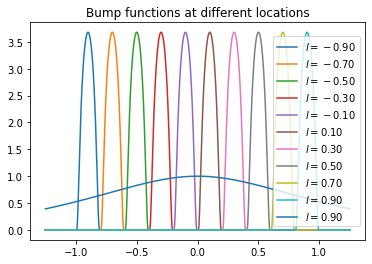

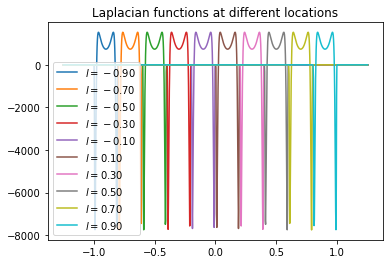

In [84]:
# Select bump functions which are 0 at the boundary
length_scale = 1.0 

epsilon_values = jnp.array([0.1])

L = 2.0 # Lenght of the domain
loc_values = jnp.linspace(-1.0 + epsilon_values[0], 1.0 - epsilon_values[0],  int(L/(2*epsilon_values[0])))

bump_values = vmap_bump(domain, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(domain, bump_values[:, 0, i], label = f"$l = {loc:.2f}$")

plt.plot(domain, vmap_kernel(domain, jnp.array([0.0]), length_scale), label = f"$l = {loc:.2f}$")
plt.legend()


plt.legend()
plt.title("Bump functions at different locations")
plt.show()

bump_values_l = vmap_bump_laplacian(domain, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(domain, bump_values_l[:, 0, i], label = f"$l = {loc:.2f}$")

plt.legend()


plt.legend()
plt.title("Laplacian functions at different locations")
plt.show()

In [85]:
epsilon_values = jnp.array([0.05])
L = 2.0 # Lenght of the domain
loc_values = jnp.linspace(-1.0 + epsilon_values[0], 1.0 - epsilon_values[0],  int(L/(2*epsilon_values[0])))

#bump_values = vmap_bump(domain, epsilon_values, loc_values)
bump_intervals =jnp.array([[l - epsilon_values[0], l + epsilon_values[0]] for l in loc_values]).T
root_psi, w_psi = vmap_root_interval(x_q, w_q, bump_intervals.T)

root_psi.shape, w_psi.shape

((20, 1000), (20, 1000))

In [86]:
1/epsilon_values

Array([20.], dtype=float64)

In [87]:
# First, we vectorize matern_kernel over the second argument, keeping the first fixed
vmapped_kernel_over_second_arg = vmap(matern_kernel, in_axes=(None, 0, None))
# Then, we vectorize the result over the first argument
vmap_kernel_vector = jit(vmap(vmapped_kernel_over_second_arg, in_axes=(0, None, None)))


vmapped_kernel_matrix_rows = jit(vmap(vmap_kernel_vector, in_axes=(None, 0, None)))
# # Vectorize the result over the second row of the pair
vmap_kernel_coll = jit(vmap(vmapped_kernel_matrix_rows, in_axes=(0, None, None)))

K_QQ = vmap_kernel_coll(root_psi, root_psi, length_scale)

In [88]:
# Testing that the vectorized kernel is correct
for i in range(root_psi.shape[0]):
    for j in range(root_psi.shape[0]):
        if not jnp.allclose(K_QQ[i,j], vmap_kernel_vector(root_psi[i], root_psi[j], length_scale)):
            print("Error")

In [90]:
def build_A(root_psi, epsilon_values, loc_values, w_psi):
    A_L = vmap(bump_laplacian, in_axes=(0, None, 0))(root_psi, epsilon_values, loc_values)
    # Multiply by the weights
    return A_L*w_psi

# From the matrix A_L
A_L = build_A(root_psi, epsilon_values, loc_values, w_psi)

A_L.shape

(20, 1000)

In [91]:
# Testing our integration

i = 0
j = 0

A_L[i]@K_QQ[i,j]@A_L[j]

Array(4.30242626, dtype=float64)

In [96]:
K_QQ.shape

(20, 20, 1000, 1000)

In [98]:
# Testing our integration in 1D
epsilon = 0.05
i = 4
j = 14
l = loc_values[j]
m = 568 # m can range from 0 to 1000 (n_order)
print((K_QQ[i,j, m]@A_L[j]))

from scipy.integrate import quad

f_integrand = lambda x: bump_laplacian(x, epsilon, l)*matern_kernel(x,root_psi[i, m] , length_scale)

quad(f_integrand, l - epsilon, l + epsilon)

-0.13595736630724614


(-0.13595736613557996, 1.0362378601303228e-09)

In [124]:
from scipy.integrate import dblquad

i = 1
j = 10
f_intergrand = lambda x, y: bump_laplacian(x, epsilon_values[0], loc_values[i]) * matern_kernel(x, y, length_scale) * bump_laplacian(y, epsilon_values[0], loc_values[j])
dblquad(f_intergrand, loc_values[i] - epsilon_values[0], loc_values[i] + epsilon_values[0],loc_values[j] - epsilon_values[0], loc_values[j] + epsilon_values[0], epsabs=1.49e-08, epsrel=1.49e-08)

(0.0, 0)

In [125]:
A_L[i]@K_QQ[i,j]@A_L[j]

Array(-0.66099846, dtype=float64)

In [33]:
i = 0
j = 12

vmap_kernel(root_psi[i], root_psi[j], length_scale).shape

(1000, 1000)

In [31]:
root_psi[0].shape

(1000,)

In [25]:
matrix.shape

(3, 2)

In [32]:
# From the matrix A_L

epsilon_values = jnp.array([0.05])
L = 2.0 # Lenght of the domain
loc_values = jnp.linspace(-1.0 + epsilon_values[0], 1.0 - epsilon_values[0],  int(L/(2*epsilon_values[0])))

#bump_values = vmap_bump(domain, epsilon_values, loc_values)
bump_intervals =jnp.array([[l - epsilon_values[0], l + epsilon_values[0]] for l in loc_values]).T
root_psi, w_psi = vmap_root_interval(x_q, w_q, bump_intervals.T)

root_psi.shape, w_psi.shape

((20, 1000), (20, 1000))

In [41]:
def build_A(root_psi, epsilon_values, loc_values, w_psi):
    A_L = vmap(bump_laplacian, in_axes=(0, None, 0))(root_psi, epsilon_values, loc_values)
    # Multiply by the weights
    return A_L*w_psi

A_L = build_A(root_psi, epsilon_values, loc_values, w_q)

A_L.shape, loc_values.shape

((20, 1000), (20,))

In [42]:
bump_intervals.shape, root_psi.shape

((2, 20), (20, 1000))

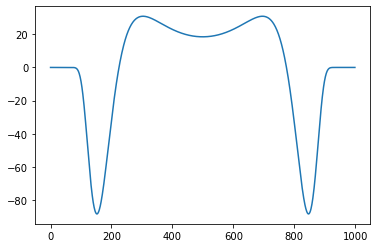

In [43]:
plt.plot(A_L[0])

In [44]:
# We define a function that allows us to construct the kernel matrix at collocation points

def kernel_for_vector(v, l):
    return vmap_kernel(v, v, l)

vmap_kernel_vect = vmap(kernel_for_vector, in_axes=(0, None))
K_QQ = vmap_kernel_vect(root_psi, l)

K_QQ

Array([[[1.        , 1.        , 1.        , ..., 0.99792289,
         0.99792284, 0.99792281],
        [1.        , 1.        , 1.        , ..., 0.99792291,
         0.99792287, 0.99792284],
        [1.        , 1.        , 1.        , ..., 0.99792296,
         0.99792291, 0.99792289],
        ...,
        [0.99792289, 0.99792291, 0.99792296, ..., 1.        ,
         1.        , 1.        ],
        [0.99792284, 0.99792287, 0.99792291, ..., 1.        ,
         1.        , 1.        ],
        [0.99792281, 0.99792284, 0.99792289, ..., 1.        ,
         1.        , 1.        ]],

       [[1.        , 1.        , 1.        , ..., 0.99792289,
         0.99792284, 0.99792281],
        [1.        , 1.        , 1.        , ..., 0.99792291,
         0.99792287, 0.99792284],
        [1.        , 1.        , 1.        , ..., 0.99792296,
         0.99792291, 0.99792289],
        ...,
        [0.99792289, 0.99792291, 0.99792296, ..., 1.        ,
         1.        , 1.        ],
        [0.9

In [45]:
for i in range(len(loc_values)):
    if not jnp.allclose(K_QQ[i], vmap_kernel(root_psi[i], root_psi[i], l)):
        print("Error")

In [46]:
# Compute the integral 
def bilinear_form(x, A):
    # Compute the matrix-vector product Ax
    Ax = jnp.dot(A, x)
    # Compute the dot product x^T(Ax)
    return jnp.dot(x, Ax)

# Vectorize the bilinear_form function over the batch dimension
batched_bilinear_form = vmap(bilinear_form, in_axes=(0, 0))

# Compute the integral
K_chi = batched_bilinear_form(A_L, K_QQ)

K_chi

Array([115.10109913, 115.10122136, 115.1012456 , 115.10125455,
       115.10124623, 115.10124322, 115.10124577, 115.10124683,
       115.10124687, 115.10124691, 115.10124691, 115.10124693,
       115.10124683, 115.10124718, 115.10124926, 115.10125002,
       115.10125455, 115.10120792, 115.10123536, 115.10109913],      dtype=float64)

In [52]:
K_QQ.shape, A_L.shape, root_psi.shape

((20, 1000, 1000), (20, 1000), (20, 1000))

In [47]:
(K_QQ[0]@A_L[0])[0]

Array(3.68106931, dtype=float64)

In [134]:
from scipy.integrate import quad

l = loc_values[0]
epsilon = 0.05

domain_eps = jnp.linspace(l - epsilon, l + epsilon, 1000)
f = lambda x: bump_laplacian(x, epsilon, l)*matern_kernel(x, domain_eps[0], length_scale)

f(0.0)

K_QQ =  vmap_kernel_vect(domain_eps[None], length_scale)

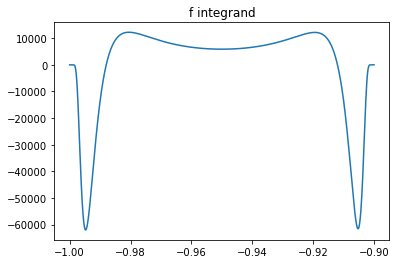

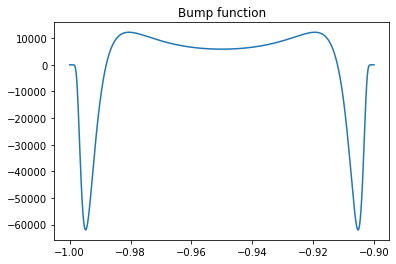

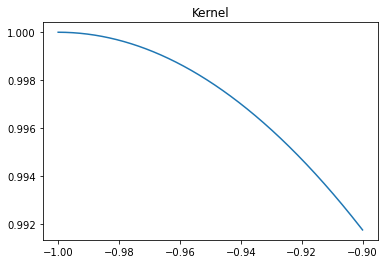

In [135]:
def build_A(root_psi, epsilon_values, loc_values, w_psi):
    A_L = vmap(bump_laplacian, in_axes=(0, None, 0))(root_psi, epsilon_values, loc_values)
    # Multiply by the weights
    return A_L


A_L = build_A(domain_eps[None], epsilon_values, jnp.array([l]), w_q)

A_L.shape
f_values_2 = K_QQ[0, 0]*A_L[0]

plt.figure()
plt.plot(domain_eps, f_values_2)
plt.title("f integrand")
plt.show()

plt.figure()
plt.plot(domain_eps, A_L[0])
plt.title("Bump function")
plt.show()


plt.figure()
plt.plot(domain_eps, K_QQ[0, 0])
plt.title("Kernel")
plt.show()

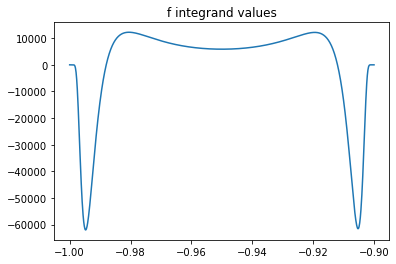

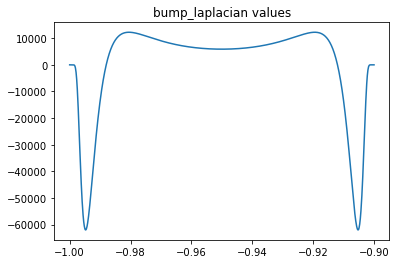

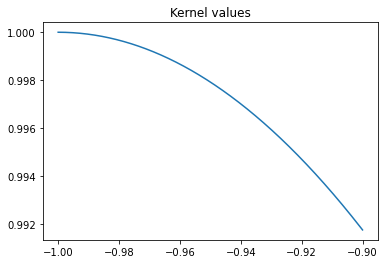

In [120]:

plt.figure()
f_values = jnp.array([f(x) for x in domain_eps])
plt.plot(domain_eps, f_values)
plt.title("f integrand values")
plt.show()

plt.figure()
bump_l_values = jnp.array([bump_laplacian(x, epsilon, l) for x in domain_eps])
plt.plot(domain_eps, bump_l_values)
plt.title("bump_laplacian values")
plt.show()

plt.figure()
K_values = jnp.array([matern_kernel(x, domain_eps[0], length_scale) for x in domain_eps])
plt.plot(domain_eps, K_values)
plt.title("Kernel values")
plt.show()

In [121]:
jnp.allclose(K_QQ[0,0], jnp.array(K_values)), jnp.allclose(A_L[0], bump_l_values), jnp.allclose(f_values_2, f_values)

(Array(True, dtype=bool), Array(True, dtype=bool), Array(True, dtype=bool))

In [126]:
jnp.mean(f_values), l-epsilon, l+epsilon    

(Array(7.25089636, dtype=float64),
 Array(-1., dtype=float64),
 Array(-0.9, dtype=float64))

In [141]:
(K_QQ[0, 0]@A_L[0])/A_L.shape[1], quad(f, l - epsilon, l + epsilon)

(Array(7.25089636, dtype=float64), (0.7258154027881449, 4.758192884562757e-09))

In [149]:
def build_A(root_psi, epsilon_values, loc_values, w_psi):
    A_L = vmap(bump_laplacian, in_axes=(0, None, 0))(root_psi, epsilon_values, loc_values)
    # Multiply by the weights
    return A_L*w_psi


#bump_values = vmap_bump(domain, epsilon_values, loc_values)
bump_intervals =jnp.array([[l - epsilon_values[0], l + epsilon_values[0]]]).T
root_psi, w_psi = vmap_root_interval(x_q, w_q, bump_intervals.T)

A_L = build_A(root_psi, epsilon_values, jnp.array([l]), w_psi)

K_QQ =  vmap_kernel_vect(root_psi, length_scale)

K_QQ.shape, A_L.shape

((1, 1000, 1000), (1, 1000))

In [150]:
K_QQ[0,0]@A_L[0]

Array(0.72581554, dtype=float64)

In [143]:
root_psi.shape

(20, 1000)

In [123]:
A_L.shape[1]

1000

In [52]:
quad(f, l - epsilon, l + epsilon)

(0.7265398912515266, 1.914124995516049e-09)

In [37]:
# Testing our integration

from scipy.integrate import dblquad
l = 0.0
epsilon = 0.05
f = lambda x,y: bump_laplacian(x, epsilon, l)*matern_kernel(x, y, length_scale)*bump_laplacian(y, epsilon, l)

In [38]:
epsilon = 0.05
f(-epsilon+0.0001, 0)

Array(-1.51371487e-91, dtype=float64)

In [39]:
dblquad(f, l - epsilon , l+ epsilon, lambda x: l-epsilon, lambda x: l+epsilon)

(4.30242772757131, 0.00011870436244443283)

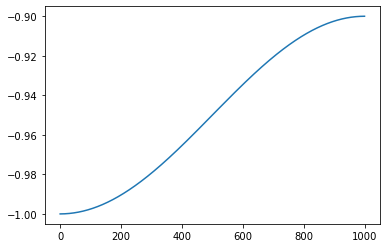

In [41]:
plt.plot(root_psi[0])